# 1. [Standard SL] Melatih Sebuah Neural Networks Secara *Supervise Learning*
Training data: MNIST 5k 
Path to data: './data/training_subdata.bin'

## Import Modules

In [1]:
import os
import time as timer

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import numpy as np

from sklearn.preprocessing import MinMaxScaler

from torchvision import datasets
import torchvision.transforms as T

from joblib import dump, load

In [2]:
from ffnn import FFNN_v2
import train_utils as tu
import visualization_utils as vu

## Define Constants

In [3]:
DATA_DIR = "./data"
MODEL_DIR = "./models"

EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 1e-5

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Load Data

In [4]:
training_data = load('./data/training_subdata.bin')
training_data

Dataset MNIST
    Number of datapoints: 5000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data = datasets.MNIST(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=T.ToTensor(), #convert to Tensor and normalize to (0, 1)
)

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
"""
Create data loaders
"""
train_dl = DataLoader(training_data, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE)

### Visualize some data

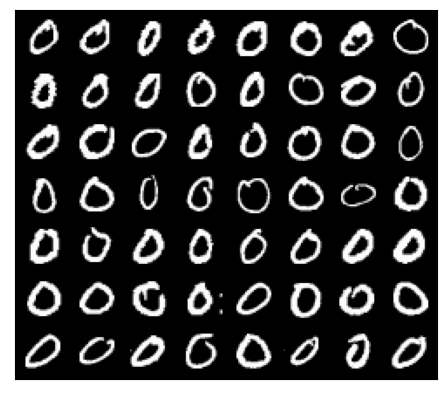

In [8]:
grid = vu.set_grid(train_dl.dataset.data, num_cells=56)
vu.show(grid)

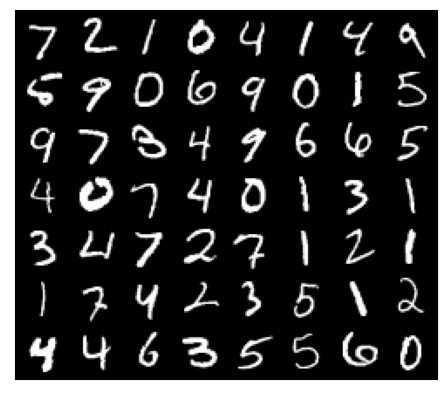

In [9]:
grid = vu.set_grid(test_dl.dataset.data, num_cells=56)
vu.show(grid)

## FFNN Model

### Define Model

In [10]:
print(f"Using {DEVICE} device")

# Define model
model = FFNN_v2().to(DEVICE)
print(model)

# Persistent file to store the model
model_path = os.path.join(MODEL_DIR, "ffnn_v3_mnist.pth")

Using cuda device
FFNN_v2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=10, bias=True)
  )
)


### Define the Loss Function and the Optimizer

In [11]:
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.parameters(), 
    lr=LEARNING_RATE
)

### Train and Test Helper Function

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    """
    Mini-batched training
    
    Args:
        dataloader ()     : 
        model (nn.Module) : 
        loss_fn ()        : loss/objective function
        optimizer ()      : optimization algorithm
    """
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(DEVICE), y.to(DEVICE)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f} [{current:>5d}]/{size:>5d}")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    accuracy = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    accuracy += 100*correct
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return accuracy

### Execute the Training

In [13]:
test_accuracy = []
train_accuracy = []
for t in range(EPOCHS):
    print(f"Epoch {t+1} out of {EPOCHS}\n ------------")
    
    start = timer.time()
    train(train_dl, model, loss_fn, optimizer)
    elapsed_time = timer.time() - start # this timing method ONLY works for CPU computation, not for GPU/cuda calls
    print(f" > Training time: {elapsed_time:>.2f} seconds")
    
    print("Test Set Error:")
    acc_test = test(test_dl, model, loss_fn)
    print("\nTrain Set Error:")
    acc_train = test(train_dl, model, loss_fn)
    test_accuracy.append(acc_test)
    train_accuracy.append(acc_train)
    
    # Save model
    torch.save(model.state_dict(), model_path)
    print(f"Model {model_path} stored!")
    
print("Done!")

Epoch 1 out of 100
 ------------
Loss: 2.288391 [    0]/ 5000
Loss: 2.317553 [ 1600]/ 5000
Loss: 2.369200 [ 3200]/ 5000
Loss: 2.306103 [ 4800]/ 5000
 > Training time: 3.63 seconds
Test Set Error:
Test Error: 
 Accuracy: 42.3%, Avg loss: 2.262645 


Train Set Error:
Test Error: 
 Accuracy: 42.4%, Avg loss: 2.261602 

Model ./models\ffnn_v3_mnist.pth stored!
Epoch 2 out of 100
 ------------
Loss: 2.215110 [    0]/ 5000
Loss: 2.271809 [ 1600]/ 5000
Loss: 2.279577 [ 3200]/ 5000
Loss: 2.288564 [ 4800]/ 5000
 > Training time: 1.11 seconds
Test Set Error:
Test Error: 
 Accuracy: 66.7%, Avg loss: 2.213319 


Train Set Error:
Test Error: 
 Accuracy: 69.1%, Avg loss: 2.210885 

Model ./models\ffnn_v3_mnist.pth stored!
Epoch 3 out of 100
 ------------
Loss: 2.135169 [    0]/ 5000
Loss: 2.246992 [ 1600]/ 5000
Loss: 2.199037 [ 3200]/ 5000
Loss: 2.264295 [ 4800]/ 5000
 > Training time: 1.09 seconds
Test Set Error:
Test Error: 
 Accuracy: 75.4%, Avg loss: 2.142920 


Train Set Error:
Test Error: 
 Ac

Loss: 1.143917 [ 1600]/ 5000
Loss: 0.326507 [ 3200]/ 5000
Loss: 0.832732 [ 4800]/ 5000
 > Training time: 1.19 seconds
Test Set Error:
Test Error: 
 Accuracy: 83.6%, Avg loss: 0.608130 


Train Set Error:
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.582343 

Model ./models\ffnn_v3_mnist.pth stored!
Epoch 25 out of 100
 ------------
Loss: 0.375743 [    0]/ 5000
Loss: 1.119452 [ 1600]/ 5000
Loss: 0.316581 [ 3200]/ 5000
Loss: 0.801325 [ 4800]/ 5000
 > Training time: 1.22 seconds
Test Set Error:
Test Error: 
 Accuracy: 83.9%, Avg loss: 0.591385 


Train Set Error:
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.564371 

Model ./models\ffnn_v3_mnist.pth stored!
Epoch 26 out of 100
 ------------
Loss: 0.356846 [    0]/ 5000
Loss: 1.095790 [ 1600]/ 5000
Loss: 0.307600 [ 3200]/ 5000
Loss: 0.771549 [ 4800]/ 5000
 > Training time: 1.14 seconds
Test Set Error:
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.576045 


Train Set Error:
Test Error: 
 Accuracy: 85.7%, Avg loss: 0.547796 

Model ./models\ffnn_v3_m

Loss: 0.803010 [ 1600]/ 5000
Loss: 0.219530 [ 3200]/ 5000
Loss: 0.400491 [ 4800]/ 5000
 > Training time: 1.18 seconds
Test Set Error:
Test Error: 
 Accuracy: 87.9%, Avg loss: 0.409962 


Train Set Error:
Test Error: 
 Accuracy: 90.2%, Avg loss: 0.357809 

Model ./models\ffnn_v3_mnist.pth stored!
Epoch 48 out of 100
 ------------
Loss: 0.118674 [    0]/ 5000
Loss: 0.795432 [ 1600]/ 5000
Loss: 0.217302 [ 3200]/ 5000
Loss: 0.390921 [ 4800]/ 5000
 > Training time: 1.17 seconds
Test Set Error:
Test Error: 
 Accuracy: 88.0%, Avg loss: 0.405831 


Train Set Error:
Test Error: 
 Accuracy: 90.3%, Avg loss: 0.352636 

Model ./models\ffnn_v3_mnist.pth stored!
Epoch 49 out of 100
 ------------
Loss: 0.113715 [    0]/ 5000
Loss: 0.788155 [ 1600]/ 5000
Loss: 0.215187 [ 3200]/ 5000
Loss: 0.381692 [ 4800]/ 5000
 > Training time: 1.14 seconds
Test Set Error:
Test Error: 
 Accuracy: 88.1%, Avg loss: 0.401886 


Train Set Error:
Test Error: 
 Accuracy: 90.4%, Avg loss: 0.347652 

Model ./models\ffnn_v3_m

Loss: 0.669996 [ 1600]/ 5000
Loss: 0.179743 [ 3200]/ 5000
Loss: 0.257307 [ 4800]/ 5000
 > Training time: 1.17 seconds
Test Set Error:
Test Error: 
 Accuracy: 89.6%, Avg loss: 0.345051 


Train Set Error:
Test Error: 
 Accuracy: 92.2%, Avg loss: 0.270235 

Model ./models\ffnn_v3_mnist.pth stored!
Epoch 71 out of 100
 ------------
Loss: 0.053345 [    0]/ 5000
Loss: 0.665549 [ 1600]/ 5000
Loss: 0.178325 [ 3200]/ 5000
Loss: 0.253431 [ 4800]/ 5000
 > Training time: 1.25 seconds
Test Set Error:
Test Error: 
 Accuracy: 89.7%, Avg loss: 0.343147 


Train Set Error:
Test Error: 
 Accuracy: 92.4%, Avg loss: 0.267395 

Model ./models\ffnn_v3_mnist.pth stored!
Epoch 72 out of 100
 ------------
Loss: 0.051980 [    0]/ 5000
Loss: 0.661209 [ 1600]/ 5000
Loss: 0.176955 [ 3200]/ 5000
Loss: 0.249659 [ 4800]/ 5000
 > Training time: 1.20 seconds
Test Set Error:
Test Error: 
 Accuracy: 89.7%, Avg loss: 0.341301 


Train Set Error:
Test Error: 
 Accuracy: 92.5%, Avg loss: 0.264613 

Model ./models\ffnn_v3_m

Loss: 0.579013 [ 1600]/ 5000
Loss: 0.153544 [ 3200]/ 5000
Loss: 0.188846 [ 4800]/ 5000
 > Training time: 1.13 seconds
Test Set Error:
Test Error: 
 Accuracy: 90.5%, Avg loss: 0.310846 


Train Set Error:
Test Error: 
 Accuracy: 93.8%, Avg loss: 0.215181 

Model ./models\ffnn_v3_mnist.pth stored!
Epoch 94 out of 100
 ------------
Loss: 0.031416 [    0]/ 5000
Loss: 0.575401 [ 1600]/ 5000
Loss: 0.152520 [ 3200]/ 5000
Loss: 0.186607 [ 4800]/ 5000
 > Training time: 1.17 seconds
Test Set Error:
Test Error: 
 Accuracy: 90.6%, Avg loss: 0.309669 


Train Set Error:
Test Error: 
 Accuracy: 93.9%, Avg loss: 0.213139 

Model ./models\ffnn_v3_mnist.pth stored!
Epoch 95 out of 100
 ------------
Loss: 0.030803 [    0]/ 5000
Loss: 0.571671 [ 1600]/ 5000
Loss: 0.151633 [ 3200]/ 5000
Loss: 0.184357 [ 4800]/ 5000
 > Training time: 1.28 seconds
Test Set Error:
Test Error: 
 Accuracy: 90.6%, Avg loss: 0.308538 


Train Set Error:
Test Error: 
 Accuracy: 93.9%, Avg loss: 0.211137 

Model ./models\ffnn_v3_m

In [14]:
train_accuracy

[42.38,
 69.06,
 77.02,
 78.78,
 79.34,
 79.38,
 79.0,
 78.96,
 79.06,
 79.44,
 79.92,
 80.46,
 80.9,
 81.3,
 81.84,
 82.3,
 82.96,
 83.24000000000001,
 83.67999999999999,
 83.98,
 84.34,
 84.66,
 84.76,
 85.11999999999999,
 85.38,
 85.68,
 85.92,
 86.22,
 86.44,
 86.7,
 86.94,
 87.14,
 87.36,
 87.56,
 87.88,
 88.22,
 88.34,
 88.6,
 88.82,
 89.05999999999999,
 89.3,
 89.4,
 89.56,
 89.78,
 89.86,
 90.03999999999999,
 90.18,
 90.3,
 90.44,
 90.52,
 90.66,
 90.72,
 90.84,
 90.96,
 91.0,
 91.08000000000001,
 91.2,
 91.18,
 91.28,
 91.38,
 91.44,
 91.56,
 91.62,
 91.74,
 91.8,
 91.96,
 92.02,
 92.02,
 92.10000000000001,
 92.22,
 92.36,
 92.47999999999999,
 92.54,
 92.67999999999999,
 92.80000000000001,
 92.82000000000001,
 92.9,
 93.0,
 93.10000000000001,
 93.14,
 93.22,
 93.34,
 93.34,
 93.36,
 93.38,
 93.44,
 93.5,
 93.52000000000001,
 93.62,
 93.67999999999999,
 93.7,
 93.78,
 93.82000000000001,
 93.86,
 93.94,
 94.06,
 94.16,
 94.17999999999999,
 94.28,
 94.3]

In [15]:
test_accuracy

[42.27,
 66.66,
 75.41,
 77.55,
 77.82,
 77.8,
 77.24,
 77.49000000000001,
 77.8,
 78.23,
 78.71000000000001,
 79.45,
 79.88,
 80.22,
 80.52,
 80.88,
 81.25,
 81.67999999999999,
 81.96,
 82.28,
 82.63000000000001,
 82.98,
 83.3,
 83.63000000000001,
 83.93,
 84.19,
 84.49,
 84.78,
 85.11999999999999,
 85.37,
 85.63,
 85.75,
 86.02,
 86.22,
 86.41,
 86.59,
 86.69,
 86.86,
 87.03999999999999,
 87.16000000000001,
 87.27000000000001,
 87.42999999999999,
 87.49,
 87.57000000000001,
 87.68,
 87.83,
 87.9,
 87.99,
 88.09,
 88.19,
 88.31,
 88.44999999999999,
 88.56,
 88.61,
 88.75,
 88.82,
 88.89,
 88.92999999999999,
 88.98,
 89.03,
 89.12,
 89.18,
 89.23,
 89.25999999999999,
 89.29,
 89.33,
 89.35,
 89.4,
 89.51,
 89.60000000000001,
 89.67,
 89.74,
 89.81,
 89.85,
 89.89,
 89.9,
 90.02,
 90.06,
 90.08,
 90.11,
 90.14,
 90.13,
 90.14999999999999,
 90.19,
 90.25999999999999,
 90.33,
 90.35,
 90.36,
 90.39,
 90.42999999999999,
 90.47,
 90.5,
 90.55,
 90.60000000000001,
 90.63,
 90.68,
 90.68,
 90

## Accuracy Plot

In [16]:
import matplotlib.pyplot as plt
import numpy as np

In [32]:
# Plotting Helper Function
def plot_acc_epoch(epochs, train_acc, test_acc):
    l = range(1,epochs+1)
    N = len(l)
    l2 = np.arange(N)
    plt.subplots(figsize=(10, 5))
    plt.plot(l2, test_acc, label="Testing Accuracy")
    plt.plot(l2, train_acc, label="Training Accuracy")
#     plt.xticks(l2,l)
    plt.grid(True)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title('Accuracy versus Epoch FFNN Model', fontsize=12)
    plt.show()

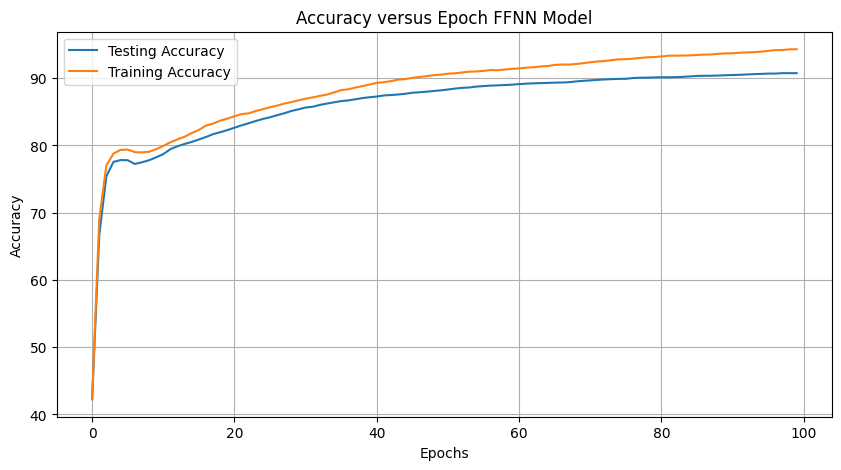

In [33]:
plot_acc_epoch(100, train_accuracy, test_accuracy)

In [20]:
max(train_accuracy), max(test_accuracy)

(94.3, 90.74)

In [21]:
train_accuracy[-1], test_accuracy[-1]

(94.3, 90.74)